# CLUSTER algorithm **Kopuru Vespa Velutina Competition**

Purpose: Cluster the municipalities of Biscay using the total number of vespa velutina nests found in 2019 and 2018 as features.

Outputs: CLUSTERSnests datasets *(WBds_CLUSTERSnests.csv)*

@authors:
* mario.bejar@student.ie.edu
* pedro.geirinhas@student.ie.edu
* a.berrizbeitia@student.ie.edu
* pcasaverde@student.ie.edu

In [332]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from plotnine import *

In [333]:
df01 = pd.read_csv('../../../Input_open_data/ds01_PLANTILLA-RETO-AVISPAS-KOPURU.csv', sep=";")
df02 = pd.read_csv('../../../Input_open_data/ds02_datos-nidos-avispa-asiatica.csv', sep=",")
WBdf01 = pd.read_csv('./WBds01_GEO.csv', sep=',')

## Data cleanup
### Getting the names right

In [334]:
# Dropping and Renaming columns in accordance to the DataMap
# DataMap's URL: https://docs.google.com/spreadsheets/d/1Ad7s4IOmj9Tn2WcEOz4ArwedTzDs9Y0_EaUSm6uRHMQ/edit#gid=0

df01.columns = ['municip_code', 'municip_name', 'nests_2020']
df01.drop(columns=['nests_2020'], inplace=True) # just note that this is the final variable to predict in the competition
df02.drop(columns=['JARDUERA_ZENBAKIA/NUM_ACTUACION', 'ERABILTZAILEA_EU/USUARIO_EU', 'ERABILTZAILEA_CAS/USUARIO_CAS', 'HELBIDEA/DIRECCION', 'EGOERA_EU/ESTADO_EU', 'ITXIERA_DATA/FECHA CIERRE', 'ITXIERAKO AGENTEA_EU/AGENTE CIERRE_EU', 'ITXIERAKO AGENTEA_CAS/AGENTE CIERRE_CAS'], inplace=True)
df02.columns = ['waspbust_id', 'year', 'nest_foundDate', 'municip_name', 'species', 'nest_locType', 'nest_hight', 'nest_diameter', 'nest_longitude', 'nest_latitude', 'nest_status']


In [335]:
# We don't have the "months" specified for any of the records in 2017 ('nest_foundDate' is incorrect for this year), so we'll drop those records
df02 = df02.drop(df02[df02['year'] == 2017].index, inplace = False)

In [336]:
# Cleaning municipality names in ds02 with names from ds01
df02_wrong_mun = ['ABADIÑO' ,'ABANTO Y CIERVANA' ,'ABANTO Y CIERVANA-ABANTO ZIERBENA' ,'AJANGIZ' ,'ALONSOTEGI' ,'AMOREBIETA-ETXANO' ,'AMOROTO' ,'ARAKALDO' ,'ARANTZAZU' ,'AREATZA' ,'ARRANKUDIAGA' ,'ARRATZU' ,'ARRIETA' ,'ARRIGORRIAGA' ,'ARTEA' ,'ARTZENTALES' ,'ATXONDO' ,'AULESTI' ,'BAKIO' ,'BALMASEDA' ,'BARAKALDO' ,'BARRIKA' ,'BASAURI' ,'BEDIA' ,'BERANGO' ,'BERMEO' ,'BERRIATUA' ,'BERRIZ' ,'BUSTURIA' ,'DERIO' ,'DIMA' ,'DURANGO' ,'EA' ,'ELANTXOBE' ,'ELORRIO' ,'ERANDIO' ,'EREÑO' ,'ERMUA' ,'ERRIGOITI' ,'ETXEBARRI' ,'ETXEBARRIA', 'ETXEBARRIa','FORUA' ,'FRUIZ' ,'GALDAKAO' ,'GALDAMES' ,'GAMIZ-FIKA' ,'GARAI' ,'GATIKA' ,'GAUTEGIZ ARTEAGA' ,'GERNIKA-LUMO' ,'GETXO' ,'GETXO ' ,'GIZABURUAGA' ,'GORDEXOLA' ,'GORLIZ' ,'GUEÑES' ,'IBARRANGELU' ,'IGORRE' ,'ISPASTER' ,'IURRETA' ,'IZURTZA' ,'KARRANTZA HARANA/VALLE DE CARRANZA' ,'KARRANTZA HARANA-VALLE DE CARRANZA' ,'KORTEZUBI' ,'LANESTOSA' ,'LARRABETZU' ,'LAUKIZ' ,'LEIOA' ,'LEKEITIO' ,'LEMOA' ,'LEMOIZ' ,'LEZAMA' ,'LOIU' ,'MALLABIA' ,'MAÑARIA' ,'MARKINA-XEMEIN' ,'MARURI-JATABE' ,'MEÑAKA' ,'MENDATA' ,'MENDEXA' ,'MORGA' ,'MUNDAKA' ,'MUNGIA' ,'MUNITIBAR-ARBATZEGI' ,'MUNITIBAR-ARBATZEGI GERRIKAITZ' ,'MURUETA' ,'MUSKIZ' ,'MUXIKA' ,'NABARNIZ' ,'ONDARROA' ,'OROZKO' ,'ORTUELLA' ,'OTXANDIO' ,'PLENTZIA' ,'PORTUGALETE' ,'SANTURTZI' ,'SESTAO' ,'SONDIKA' ,'SOPELA' ,'SOPUERTA' ,'SUKARRIETA' ,'TRUCIOS-TURTZIOZ' ,'UBIDE' ,'UGAO-MIRABALLES' ,'URDULIZ' ,'URDUÑA/ORDUÑA' ,'URDUÑA-ORDUÑA' ,'VALLE DE TRAPAGA' ,'VALLE DE TRAPAGA-TRAPAGARAN' ,'ZALDIBAR' ,'ZALLA' ,'ZAMUDIO' ,'ZARATAMO' ,'ZEANURI' ,'ZEBERIO' ,'ZIERBENA' ,'ZIORTZA-BOLIBAR' ]
df02_correct_mun = ['Abadiño' ,'Abanto y Ciérvana-Abanto Zierbena' ,'Abanto y Ciérvana-Abanto Zierbena' ,'Ajangiz' ,'Alonsotegi' ,'Amorebieta-Etxano' ,'Amoroto' ,'Arakaldo' ,'Arantzazu' ,'Areatza' ,'Arrankudiaga' ,'Arratzu' ,'Arrieta' ,'Arrigorriaga' ,'Artea' ,'Artzentales' ,'Atxondo' ,'Aulesti' ,'Bakio' ,'Balmaseda' ,'Barakaldo' ,'Barrika' ,'Basauri' ,'Bedia' ,'Berango' ,'Bermeo' ,'Berriatua' ,'Berriz' ,'Busturia' ,'Derio' ,'Dima' ,'Durango' ,'Ea' ,'Elantxobe' ,'Elorrio' ,'Erandio' ,'Ereño' ,'Ermua' ,'Errigoiti' ,'Etxebarri' , 'Etxebarria', 'Etxebarria','Forua' ,'Fruiz' ,'Galdakao' ,'Galdames' ,'Gamiz-Fika' ,'Garai' ,'Gatika' ,'Gautegiz Arteaga' ,'Gernika-Lumo' ,'Getxo' ,'Getxo' ,'Gizaburuaga' ,'Gordexola' ,'Gorliz' ,'Güeñes' ,'Ibarrangelu' ,'Igorre' ,'Ispaster' ,'Iurreta' ,'Izurtza' ,'Karrantza Harana/Valle de Carranza' ,'Karrantza Harana/Valle de Carranza' ,'Kortezubi' ,'Lanestosa' ,'Larrabetzu' ,'Laukiz' ,'Leioa' ,'Lekeitio' ,'Lemoa' ,'Lemoiz' ,'Lezama' ,'Loiu' ,'Mallabia' ,'Mañaria' ,'Markina-Xemein' ,'Maruri-Jatabe' ,'Meñaka' ,'Mendata' ,'Mendexa' ,'Morga' ,'Mundaka' ,'Mungia' ,'Munitibar-Arbatzegi Gerrikaitz' ,'Munitibar-Arbatzegi Gerrikaitz' ,'Murueta' ,'Muskiz' ,'Muxika' ,'Nabarniz' ,'Ondarroa' ,'Orozko' ,'Ortuella' ,'Otxandio' ,'Plentzia' ,'Portugalete' ,'Santurtzi' ,'Sestao' ,'Sondika' ,'Sopela' ,'Sopuerta' ,'Sukarrieta' ,'Trucios-Turtzioz' ,'Ubide' ,'Ugao-Miraballes' ,'Urduliz' ,'Urduña/Orduña' ,'Urduña/Orduña' ,'Valle de Trápaga-Trapagaran' ,'Valle de Trápaga-Trapagaran' ,'Zaldibar' ,'Zalla' ,'Zamudio' ,'Zaratamo' ,'Zeanuri' ,'Zeberio' ,'Zierbena' ,'Ziortza-Bolibar',]
df02.municip_name.replace(to_replace = df02_wrong_mun, value = df02_correct_mun, inplace = True)
df02.shape

(6682, 11)

In [337]:
# Translate the `species` variable contents to English
df02.species.replace(to_replace=['AVISPA ASIÁTICA', 'AVISPA COMÚN', 'ABEJA'], value=['Vespa Velutina', 'Common Wasp', 'Wild Bee'], inplace=True)

In [338]:
# Translate the contents of the `nest_locType` and `nest_status` variables to English
# But note that this data makes is of no use from a "forecastoing" standpoint eventually, since we will predict with a one-year offset (and thus, use thigs like weather mostly)

df02.nest_locType.replace(to_replace=['CONSTRUCCIÓN', 'ARBOLADO'], value=['Urban Environment', 'Natural Environment'], inplace=True)
df02.nest_status.replace(to_replace=['CERRADA - ELIMINADO', 'CERRADA - NO ELIMINABLE', 'PENDIENTE DE GRUPO'], value=['Nest Terminated', 'Cannot Terminate', 'Pending classification'], inplace=True)

In [339]:
# Merge dataFrames df01 and df02 by 'municip_name', in order to identify every wasp nest with its 'municip_code'

every_wasp = pd.merge(df02, df01, how = 'left', on = 'municip_name')

### Counting the amount of wasp nests in each municipality

In [340]:
clusters = every_wasp.loc[every_wasp.species == 'Vespa Velutina', ['year', 'waspbust_id', 'municip_name', 'municip_code']].loc[every_wasp.year == 2019,:]\
.groupby(by =['year','municip_name', 'municip_code'], as_index = False).count()
clusters.shape

(109, 4)

From the shape, we can see that there are 2 missing municipalities. 
We'll find them and add them to the dataset with zero as the imputed number of nests.

In [341]:
check_1 = set(df02.municip_name) - set(clusters.municip_name)

In [342]:
check_1

{'Muskiz', 'Ubide'}

In [343]:
aux = pd.DataFrame({"year":[2019, 2019],   
                    "municip_name":['Muskiz', 'Ubide'],
                    "municip_code":[48071, 48088],
                     "waspbust_id":[0, 0]
                   })

In [344]:
clusters = clusters.append(aux, ignore_index = True)

In [345]:
clusters.shape

(111, 4)

In [346]:
set(df02.municip_name) - set(clusters.municip_name)

set()

In [347]:
# let's rename the id to NESTS, now that it has been counted
clusters.rename(columns = {"waspbust_id":"NESTS_19"}, inplace = True)

#### Counting the nests in 2018

In [348]:
clusters_2 = every_wasp.loc[every_wasp.species == 'Vespa Velutina', ['year', 'waspbust_id', 'municip_name', 'municip_code']].loc[every_wasp.year == 2018,:]\
.groupby(by =['year','municip_name', 'municip_code'], as_index = False).count()

In [349]:
clusters_2.rename(columns = {"waspbust_id":"NESTS_18"}, inplace = True)

#### Adding the number of nests in 2018 to clusters.

In [350]:
clusters = pd.merge(clusters, clusters_2,how = 'left', on = 'municip_name' )

In [351]:
clusters.head()

,year_x,municip_name,municip_code_x,NESTS_19,year_y,municip_code_y,NESTS_18
0,2019,Abadiño,48001,22,2018.0,48001.0,54.0
1,2019,Abanto y Ciérvana-Abanto Zierbena,48002,47,2018.0,48002.0,92.0
2,2019,Ajangiz,48911,12,2018.0,48911.0,19.0
3,2019,Alonsotegi,48912,16,2018.0,48912.0,26.0
4,2019,Amorebieta-Etxano,48003,79,2018.0,48003.0,125.0


In [352]:
clusters = clusters.fillna(0)

In [353]:
clusters.drop(columns=['municip_code_y','year_x','year_y'], inplace=True) 

### Performing the clustering model

In [354]:
#X = X.to_numpy()

In [355]:
#X = X.reshape(-1, 1)

In [356]:
X = clusters.loc[:,['NESTS_18', 'NESTS_19']]

In [357]:
silhouettes = []

for i in range(2,10,1):
  model = KMeans(n_clusters=i)
  X = clusters.loc[:,['NESTS_18', 'NESTS_19']]
  model.fit(X)
  labels = model.labels_
  sol = silhouette_score(X, labels)
  silhouettes.append(sol)


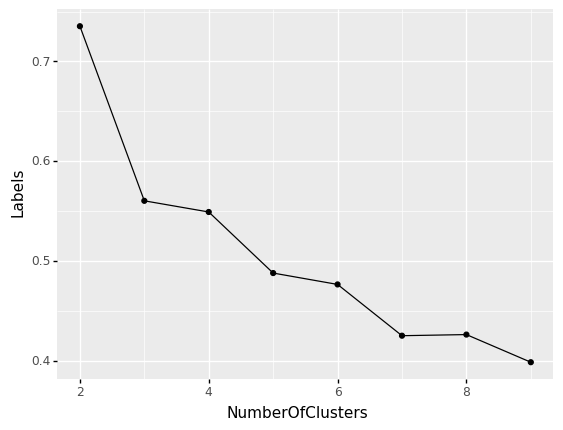

<ggplot: (154605797497)>

In [358]:
silhouette = pd.DataFrame()
silhouette['Labels'] = silhouettes
silhouette['NumberOfClusters'] = range(2,10,1)

ggplot(aes(x='NumberOfClusters', y='Labels'), silhouette) + geom_line() + geom_point()

In [359]:
kmeans = KMeans(n_clusters = 2, random_state = 0)

In [360]:
kmeans.fit(X)

KMeans(n_clusters=2, random_state=0)

In [361]:
clusters['Cluster'] = pd.Series(kmeans.labels_, index = clusters.index)

In [362]:
clusters.head()

,municip_name,municip_code_x,NESTS_19,NESTS_18,Cluster
0,Abadiño,48001,22,54.0,0
1,Abanto y Ciérvana-Abanto Zierbena,48002,47,92.0,1
2,Ajangiz,48911,12,19.0,0
3,Alonsotegi,48912,16,26.0,0
4,Amorebieta-Etxano,48003,79,125.0,1


In [363]:
clusters.rename(columns={"municip_code_x": "municip_code"}, inplace = True )

In [364]:
clusters.drop(columns=['NESTS_19', 'NESTS_18'], inplace=True) 

In [365]:
clusters.to_csv('WBds_CLUSTERSnests.csv', index=False)